# CS171 Final Project — Model Construction Notebook

This notebook contains the construction and training of our Convolutional Neural Network (CNN) for predicting video game genres from gameplay screenshots.

This notebook focuses on:
- Preparing the training and test datasets  
- Defining our CNN architecture (GameGenreCNN)  
- Training the model  
- Tracking loss and accuracy over epochs  
- Saving the trained model for later use in the Analysis & Visualization notebook



In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec

#import scipy

# Image handling
from PIL import Image

#Pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim

#Torchvision for loading images
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
#Select device
if torch.cuda.is_available():
    device_name = "cuda"
elif torch.backends.mps.is_available():
    device_name = "mps"
else:
    device_name = "cpu"
print('Using device: '+device_name)
device = torch.device(device_name)

Using device: mps


In [3]:
# Batch size for training
BATCH_SIZE = 10

# Transform: resize → tensor → normalize
transform = transforms.Compose([
    transforms.Resize((100, 100)),    #resize images to 100x100
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 3 values for RGB
])

# Load training images from folder structure:
# Images/train/<genre_name>/
train_dataset = datasets.ImageFolder(root=os.path.join('Images','train'), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load testing images
test_dataset = datasets.ImageFolder(root=os.path.join('Images','test'), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [4]:
class GameGenreCNN(nn.Module):
    
    """
    Convolutional Neural Network for classifying screenshots
    into one of five video game genres.
    """
    
    def __init__(self, num_classes):
        super(GameGenreCNN, self).__init__()
        
        # construct the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  #output 16, 100, 100
            nn.ReLU(),
            nn.MaxPool2d(2),                             #output: 16 x 50 x 50
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # output: 32 x 50 x 50
            nn.ReLU(),
            nn.MaxPool2d(2),                             # output: 32 x 25 x 25
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # output: 64 x 25 x 25
            nn.ReLU(),
            nn.MaxPool2d(2)                              # output: 64 x 12 x 12
        )
        
        # construct the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(9216, 128), #64 * 12 * 12, 128
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 5) #5 genres
        )
        
    # define the forward step
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [5]:
# Cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Initialize model and optimizer
model = GameGenreCNN(num_classes=5).to(device)
# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def compute_correct_labels(outputs, labels):
    """
    Returns number of correctly predicted labels.
    """
    correct = 0
    total = 0
    _, predicted_values = torch.max(outputs, 1)
    differences = predicted_values - labels
    for i in range(len(differences)):
        if differences[i]==0:
            correct +=1
        total += 1
    return(correct, total)

In [7]:
def training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True):
    
    """
    Full training + evaluation loop.
    Tracks loss and accuracy for both training and test sets.
    """
    
    # make empty lists to keep track of the training and testing losses
    train_losses = []
    test_losses = []
    

    for epoch in range(NUM_EPOCHS):
        
        # Run the training loop
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_images = 0
        for train_inputs, train_labels in train_loader:
            train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_inputs)
            train_correct, train_total = compute_correct_labels(outputs, train_labels)
            total_train_correct += train_correct
            total_train_images += train_total
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Run the testing loop
        model.eval()
        total_test_loss = 0.0
        total_test_correct = 0
        total_test_images = 0
        with torch.no_grad():
            for test_inputs, test_labels in test_loader:
                test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
                outputs = model(test_inputs)
                test_correct, test_total = compute_correct_labels(outputs, test_labels)
                total_test_correct += test_correct
                total_test_images += test_total
                loss = criterion(outputs, test_labels)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        if printing:
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}"+\
                  f" - Train Loss: {avg_train_loss:.4f}, "+\
                  f"Train Correct: {total_train_correct}/{total_train_images} "+\
                  f"- Test Loss: {avg_test_loss:.4f}, "+\
                  f"Test Correct: {total_test_correct}/{total_test_images} ")

    return(train_losses, test_losses)

In [8]:
# define the number of epochs
NUM_EPOCHS = 5

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader, test_loader, printing=True)

Epoch 1/5 - Train Loss: 1.1652, Train Correct: 728/1403 - Test Loss: 2.0191, Test Correct: 82/409 
Epoch 2/5 - Train Loss: 0.6033, Train Correct: 1088/1403 - Test Loss: 1.8358, Test Correct: 111/409 
Epoch 3/5 - Train Loss: 0.3198, Train Correct: 1240/1403 - Test Loss: 3.3750, Test Correct: 86/409 
Epoch 4/5 - Train Loss: 0.2054, Train Correct: 1303/1403 - Test Loss: 2.4985, Test Correct: 104/409 
Epoch 5/5 - Train Loss: 0.1288, Train Correct: 1347/1403 - Test Loss: 3.0219, Test Correct: 89/409 


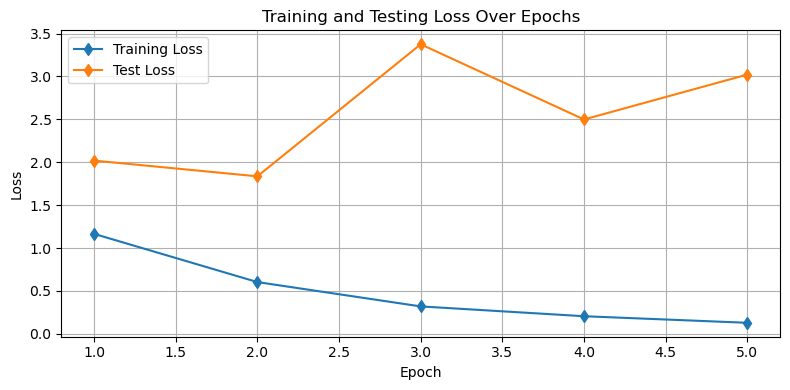

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
train_transform_augmented = transforms.Compose([
    transforms.Resize((100, 100)),

    # color and lighting variations
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3,
                               saturation=0.3, hue=0.03)
    ], p=0.7), #70% probability

    # small geometric changes (keep them mild)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=8),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),   # up to 5% shift in x/y
        scale=(0.9, 1.1)          # 90%–110% zoom
    ),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])


In [11]:
# make a data loader with the augmentation transform
train_dataset_augmented = datasets.ImageFolder(root=os.path.join('Images','train'), transform=train_transform_augmented)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=BATCH_SIZE, shuffle=True)


In [12]:
# redefine the model here in case cells are run 
# out of order for instructional purposes
model = GameGenreCNN(num_classes=5).to(device)

# Adam optimizer for stochastic gradient descent
optimizer = optim.Adam(model.parameters(), lr=0.001)

# define the number of epochs
NUM_EPOCHS = 15

# call the training loop function we defined above
train_losses, test_losses = training_loop(model, optimizer, NUM_EPOCHS, train_loader_augmented, test_loader, printing=True)

Epoch 1/15 - Train Loss: 1.3149, Train Correct: 643/1403 - Test Loss: 1.6315, Test Correct: 146/409 
Epoch 2/15 - Train Loss: 1.0258, Train Correct: 833/1403 - Test Loss: 1.8884, Test Correct: 152/409 
Epoch 3/15 - Train Loss: 0.8710, Train Correct: 937/1403 - Test Loss: 1.9692, Test Correct: 100/409 
Epoch 4/15 - Train Loss: 0.7483, Train Correct: 1002/1403 - Test Loss: 2.3369, Test Correct: 79/409 
Epoch 5/15 - Train Loss: 0.6717, Train Correct: 1049/1403 - Test Loss: 1.9581, Test Correct: 108/409 
Epoch 6/15 - Train Loss: 0.6060, Train Correct: 1102/1403 - Test Loss: 1.9822, Test Correct: 152/409 
Epoch 7/15 - Train Loss: 0.5447, Train Correct: 1126/1403 - Test Loss: 1.9980, Test Correct: 138/409 
Epoch 8/15 - Train Loss: 0.5219, Train Correct: 1136/1403 - Test Loss: 2.4989, Test Correct: 111/409 
Epoch 9/15 - Train Loss: 0.4423, Train Correct: 1173/1403 - Test Loss: 2.3563, Test Correct: 132/409 
Epoch 10/15 - Train Loss: 0.4458, Train Correct: 1176/1403 - Test Loss: 2.3596, Test C

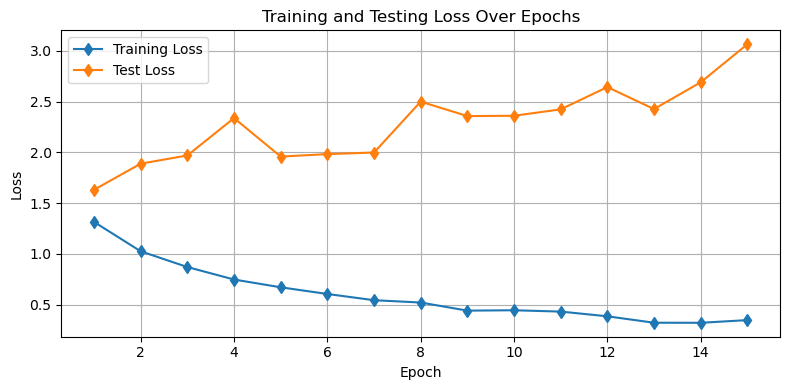

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_losses)+1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, len(test_losses)+1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
torch.save(model.state_dict(), "genre_cnn.pth")
print("Model saved as genre_cnn.pth")

Model saved as genre_cnn.pth
